In [111]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from preprocessing.utils import preprocess_data
sns.set()
preprocess_data(path='household_power_consumption.txt')

df = pd.read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime']).dropna()

df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16,3.053475,0.088187,236.24376,13.082828,0.000000,1.378788,12.439394,37.073063
2006-12-17,2.354486,0.156949,240.08702,9.999028,1.411806,2.907639,9.264584,25.657408
2006-12-18,1.530435,0.112356,241.23169,6.421667,0.738194,1.820139,9.734722,13.214190
2006-12-19,1.157079,0.104821,241.99931,4.926389,0.582639,5.279167,4.303472,9.119375
2006-12-20,1.545658,0.111804,242.30806,6.467361,0.000000,1.838889,9.765972,14.156111


In [28]:
# Augmented Dickey-Fuller test for stationary time series
ADF = adfuller(df['Global_active_power'].dropna().values)
print('ADF Statistic: %f' % ADF[0])
print('p-value: %f' % ADF[1])
print('Critical Values:')
for key, value in ADF[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.802490
p-value: 0.379226
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


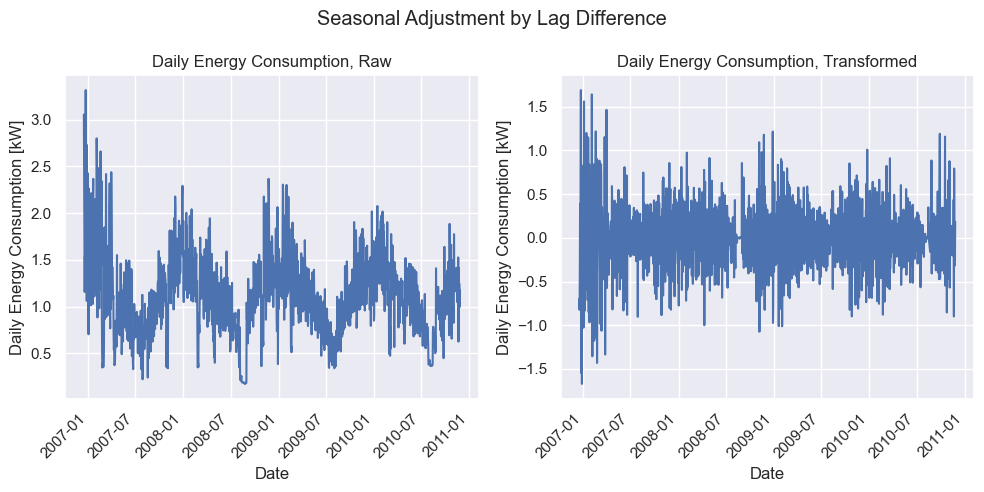

In [112]:
# Method #1: lag difference
lag_diff = df['Global_active_power'].diff()

figure, axes = plt.subplots(1, 2, figsize=(10,5))
figure.suptitle('Seasonal Adjustment by Lag Difference')
axes[0].set_title('Daily Energy Consumption, Raw')
axes[1].set_title('Daily Energy Consumption, Transformed')
sns.lineplot(ax=axes[0], data=df['Global_active_power'])
sns.lineplot(ax=axes[1], data=lag_diff)
figure.autofmt_xdate(rotation=45)
axes[0].set_xlabel('Date')
axes[1].set_xlabel('Date')
axes[0].set_ylabel('Daily Energy Consumption [kW]')
axes[1].set_ylabel('Daily Energy Consumption [kW]')
plt.tight_layout()

In [208]:
from numpy import polyfit

# Method #2: Curve fitting
series = df['Global_active_power'].dropna().values
X = [i%365 for i in range(0, len(series))]
y = series
degree = 3
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)

Coefficients: [ 8.19617101e-08 -2.14988473e-05 -2.81142012e-03  1.57083736e+00]


In [200]:
len(X)

1433

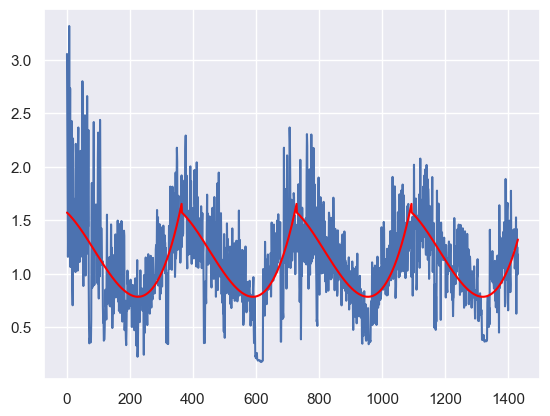

In [209]:
# create curve
curve = list()
for i in range(len(X)):
 value = coef[-1]
 for d in range(degree):
  value += X[i]**(degree-d) * coef[d]
 curve.append(value)

sns.lineplot(series)
sns.lineplot(curve, color='red')

# create seasonally adjusted
values = series
diff = list()
for i in range(len(values)):
 value = values[i] - curve[i]
 diff.append(value)


<AxesSubplot: xlabel='datetime'>

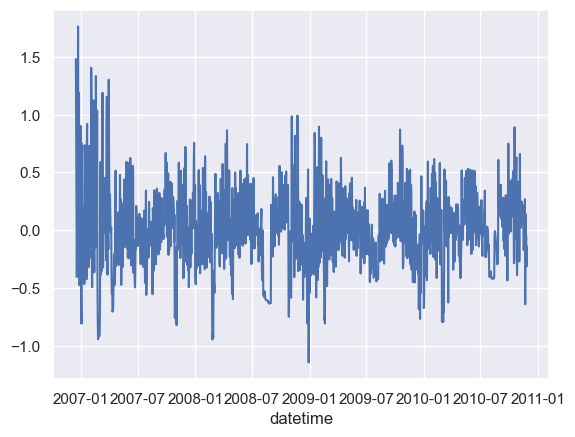

In [211]:
sns.lineplot(x=df.index, y=diff)

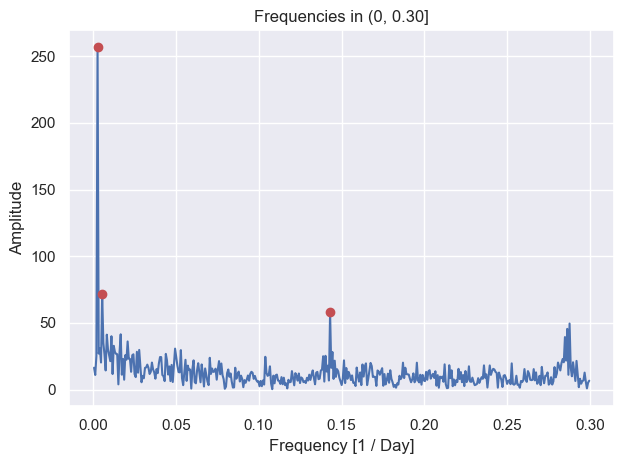

In [186]:

# Method #3: Fourier method
from scipy import fft, fftpack
from scipy import signal as sig
import matplotlib.pyplot as plt
import numpy as np

time = pd.Series([i for i in range (len(df.index))])
series = df['Global_active_power'].values #- df['Global_active_power'].mean()

fft_output = fftpack.fft(series)
power = np.abs(fft_output)
freq = fft.fftfreq(len(series))

mask = (freq > 0) & (freq <= 0.30)
plt.plot(freq[mask], power[mask])
plt.title('Frequencies in (0, 0.30]')
plt.ylabel( 'Amplitude' )
plt.xlabel( 'Frequency [1 / Day]' )

peaks = sig.find_peaks(power[freq >=0], prominence=50)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]
plt.plot(peak_freq, peak_power, 'ro')

plt.tight_layout()
plt.savefig('fft.png')

In [134]:
peak_freq


array([0.00279135, 0.00558269, 0.14305652])

In [187]:
output = pd.DataFrame()
output['index'] = peaks
output['freq (1/day)'] = peak_freq
output['amplitude'] = peak_power
output['period (days)'] = 1 / peak_freq
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)

In [188]:
output

,index,freq (1/day),amplitude,period (days),fft
0,4,0.002791,256.481719,358.250000,194.102798-167.651352j
1,8,0.005583,72.052515,179.125000,68.6192250+21.9765090j
2,205,0.143057,57.938441,6.990244,54.7998510-18.8106170j


In [189]:
filtered_fft_output = np.array([f if i == 4 or i == 8 else 0 for i, f in enumerate(fft_output)])
filtered_sig = fftpack.ifft(filtered_fft_output)
#filtered_residuals = fft.ifft(output)

In [190]:
filtered_sig

array([0.18333707-0.10165725j, 0.18480074-0.09759386j,
       0.1861639 -0.09351614j, ..., 0.17834275-0.1137335j ,
       0.18010802-0.10972988j, 0.18177283-0.10570353j])

/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


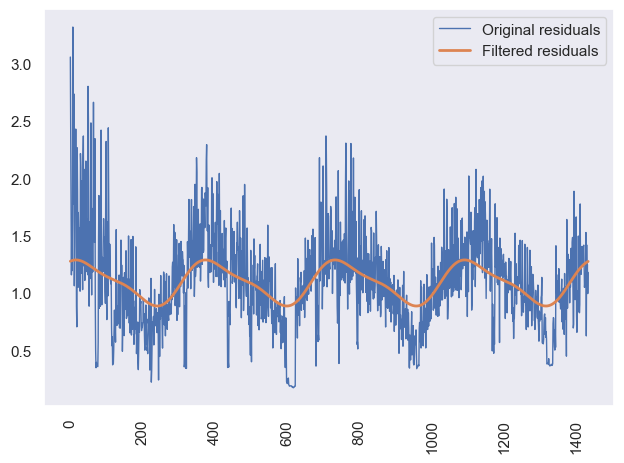

In [192]:
plt.plot(time, series, linewidth=1, label='Original residuals')
plt.plot(time, filtered_sig+series.mean(), linewidth=2, label='Filtered residuals')
plt.legend(loc='upper right')
plt.grid()

plt.xticks(rotation=90)
plt.tight_layout()

In [168]:
# Our first sine wave
import cmath
A1, f1, = 0.75, 0.002791
phase = cmath.phase(194.102798-167.651352j)
y1 = A1 * np.sin(2*np.pi * f1 * time - phase)

/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<AxesSubplot: xlabel='datetime'>

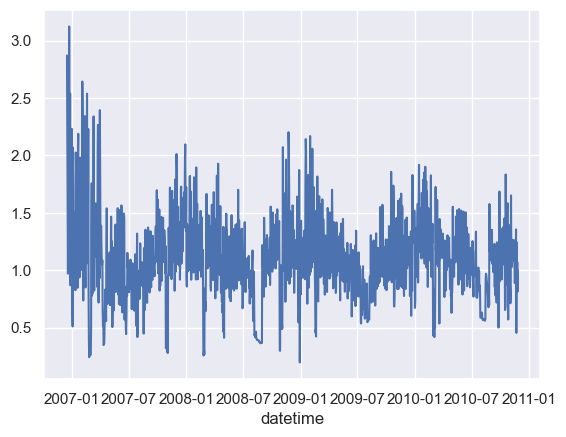

In [193]:
new_data = series - filtered_sig
sns.lineplot(x=df.index, y=new_data)